In [1]:
import geopandas as gpd
import pandas as pd

import os
repo_dir = os.environ.get("REPO_DIR")
data_dir = os.path.join(repo_dir, "data/")
code_dir = os.path.join(repo_dir, "code/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
# import pickle
# import sklearn 
import sys
import pandas as pd
from importlib import reload
import sklearn.metrics

import geopandas as gpd

import warnings

from scipy.stats import spearmanr


from analysis.NL_feature_creation_and_other_NL_processing.nl_helpers import apply_polygon_mask_and_return_flat_array

from mosaiks.utils.io import weighted_groupby

/home/groups/smhsiang/venv/hdi/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
brazil_dir = data_dir + "raw/brazil_hdi/PNUD HDRO/"

# Satellite-derived HDI for Mexican municipalities
#sat = pd.read_pickle(data_dir + "preds/hdi_preds_at_adm2.p") ## Full file is too large to GitHub repo
sat = pd.read_pickle(data_dir + "preds/hdi_preds_at_adm2_BRA_IDN_MEX.p").reset_index()
sat.rename(columns = {"adjusted_preds" : "adm2_pred","adm1_mean":"adm1_truth"},inplace=True)

sat = sat[sat["shapeGroup"] == "BRA"]

<Axes: >

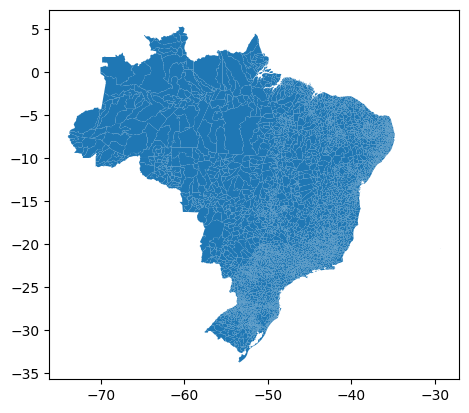

In [3]:
sat.plot()

In [4]:
df = pd.read_excel(brazil_dir + "/Atlas 2013_municipal, estadual e Brasil.xlsx")
df["adm2_true"] = df["IDHM"].astype(float)

df = df[df["ANO"] == 2010]

In [5]:
### Deal with shapefiles

In [6]:
shape_dir = brazil_dir + "Shapes/"

gpdf_list = []
for subdir in os.listdir(shape_dir):
    
    subdir_files = os.listdir(shape_dir+subdir)

    shp_file_list = [file for file in subdir_files if ".shp" in file]
    assert len(shp_file_list)==1

    shp_file = shp_file_list[0]

    state_code = int(shp_file[0:2])
    
    gpdf = gpd.read_file( os.path.join(shape_dir, subdir, shp_file))
    gpdf["state_code"] = state_code
    gpdf_list.append(gpdf)

gpdf = pd.concat(gpdf_list)
gpdf = gpdf.dropna(subset="CD_GEOCODM")

In [7]:
gpdf

,ID,CD_GEOCODU,NM_ESTADO,NM_REGIAO,geometry,state_code,CD_GEOCODM,NM_MUNICIP
0,295,NaN,NaN,NaN,"POLYGON ((-52.04050 1.40937, -52.03826 1.40855...",16,1600055,SERRA DO NAVIO
1,296,NaN,NaN,NaN,"MULTIPOLYGON (((-50.16732 1.87752, -50.17427 1...",16,1600105,AMAPÁ
2,297,NaN,NaN,NaN,"POLYGON ((-52.34902 0.43227, -52.35165 0.43867...",16,1600154,PEDRA BRANCA DO AMAPARI
3,298,NaN,NaN,NaN,"POLYGON ((-50.85494 2.49072, -50.85475 2.48999...",16,1600204,CALÇOENE
4,299,NaN,NaN,NaN,"POLYGON ((-50.45468 1.08472, -50.45403 1.08631...",16,1600212,CUTIAS
...,...,...,...,...,...,...,...,...
288,852,NaN,NaN,NaN,"POLYGON ((-49.12268 -28.47452, -49.12272 -28.4...",42,4218707,TUBARÃO
289,853,NaN,NaN,NaN,"POLYGON ((-53.70410 -26.96045, -53.70383 -26.9...",42,4218756,TUNÁPOLIS
290,854,NaN,NaN,NaN,"POLYGON ((-49.77217 -28.84358, -49.74889 -28.8...",42,4218806,TURVO
291,855,NaN,NaN,NaN,"POLYGON ((-52.85984 -26.74672, -52.85623 -26.7...",42,4218855,UNIÃO DO OESTE


In [8]:
def fix_geoid(x, str_length=7):
    assert type(x) is str
    while len(x)<str_length:
        x = "0"+x
    return x

In [9]:
df["Codmun7"] = df["Codmun7"].astype(str).apply(fix_geoid)

In [10]:
all(df["Codmun7"].isin(gpdf["CD_GEOCODM"]))

True

In [11]:
## Now we need to do the shape matching step.

In [12]:
def get_adm2_to_census_intersection(adm2, census, id_column="ADM2_PCODE"):
    
    """
    This function takes the two polygons and calculates the overlap, including the % overlap. 
    
    It returns a merged geodataframe object
    
    """
    overlaps_list = []
    percentages_list = []
    
    
    for adm2_geometry in adm2["geometry"]:
        bools = census.intersects(adm2_geometry)
        
        overlaps = list(census[id_column].loc[bools])
        
        with warnings.catch_warnings():
            #Ignore warnings about area calculations. We do not need 
            warnings.simplefilter("ignore")
            percentages = list(census.loc[bools].intersection(adm2_geometry).area / adm2_geometry.area)

        overlaps_list.append(overlaps)
        percentages_list.append(percentages)

    adm2_copy = adm2.copy()
    adm2_copy["overlaps"] = overlaps_list
    adm2_copy["percent_overlaps"] = percentages_list
    
    return adm2_copy
    

In [13]:
out = get_adm2_to_census_intersection(sat, gpdf, id_column="CD_GEOCODM")

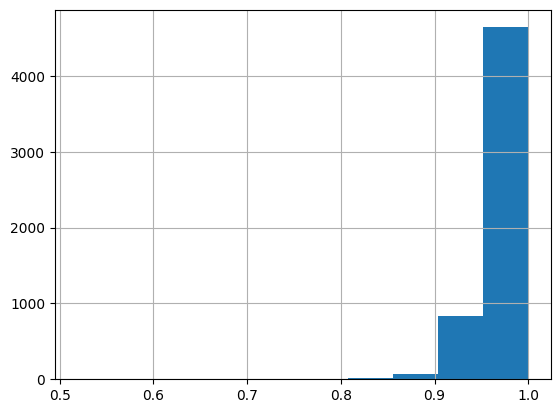

In [14]:
out["percent_overlaps"].apply(max).hist()

arg_maxes = out["percent_overlaps"].apply(np.argmax)
final_overlap_percentages = [out["percent_overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]
final_overlap_code = [out["overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]

In [15]:
out["census_code"] = final_overlap_code 
out["overlap_perc"] = final_overlap_percentages

In [16]:
## Now merge with true

In [17]:
df

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,...,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,adm2_true
11130,2010,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.80,25.49,47.37,...,16431.0,24097,22429,0.368,0.629,0.641,0.526,0.763,0.657,0.641
11131,2010,11,110002,1100023,ARIQUEMES,73.36,1.91,19.20,20.53,46.68,...,60213.0,89766,88730,0.514,0.648,0.702,0.600,0.806,0.716,0.702
11132,2010,11,110003,1100031,CABIXI,70.39,2.15,24.80,26.58,48.12,...,4306.0,6303,6156,0.357,0.700,0.650,0.559,0.757,0.650,0.650
11133,2010,11,110004,1100049,CACOAL,74.27,1.90,14.30,15.38,43.79,...,54356.0,78141,76876,0.488,0.698,0.718,0.620,0.821,0.727,0.718
11134,2010,11,110005,1100056,CEREJEIRAS,72.94,2.12,18.10,19.42,45.67,...,11786.0,16942,16815,0.430,0.712,0.692,0.602,0.799,0.688,0.692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16690,2010,52,522200,5222005,VIANÓPOLIS,74.10,2.10,14.40,17.04,45.11,...,8914.0,12501,12445,0.432,0.747,0.712,0.622,0.818,0.710,0.712
16691,2010,52,522205,5222054,VICENTINÓPOLIS,73.25,2.29,15.70,18.51,42.38,...,5190.0,7288,7239,0.389,0.676,0.684,0.562,0.804,0.707,0.684
16692,2010,52,522220,5222203,VILA BOA,74.07,2.64,14.50,17.09,50.80,...,3065.0,4685,4531,0.431,0.594,0.647,0.534,0.818,0.619,0.647
16693,2010,52,522230,5222302,VILA PROPÍCIO,73.09,2.67,15.90,18.80,50.75,...,3476.0,4739,4523,0.330,0.624,0.634,0.505,0.802,0.629,0.634


In [18]:
sat = out.merge(df[["Codmun7","adm2_true"]], how="left", left_on="census_code", right_on="Codmun7")

Text(0.5, 1.0, 'ADM2 HDI Predicted')

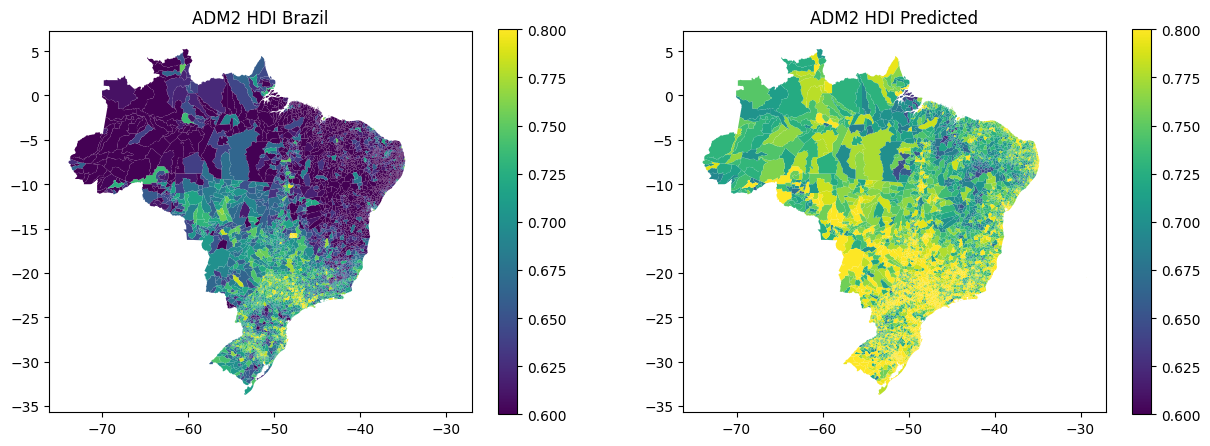

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sat.plot(column="adm2_true", ax=ax[0], legend=True, vmin=.6, vmax=.80)
ax[0].set_title("ADM2 HDI Brazil")

sat.plot(column="adm2_pred", ax=ax[1], legend=True, vmin=.6, vmax=.80)
ax[1].set_title("ADM2 HDI Predicted")

In [20]:
## Now compare perf

In [21]:
data = sat.copy()
data = data.rename(columns = {"adm2_true":"mhdi"}) # Rename so as to be consistent with the mexico stuff

In [22]:
null_count = data["adm2_pred"].isnull().sum() + data["mhdi"].isnull().sum()

print("We dont have preds for", null_count, "ADM2 observations. These will be dropped")

print("This is", round(null_count/len(data) * 100,2), "% of the data.")

data.dropna(subset = ["adm2_pred", "mhdi"], inplace=True)

We dont have preds for 1 ADM2 observations. These will be dropped
This is 0.02 % of the data.


In [23]:
data["within_adm0_true"] = data["mhdi"] - data["mhdi"].mean()
data["within_adm0_pred"] = data["adm2_pred"] - data["adm2_pred"].mean()

In [24]:
adm1_pred_means = data.groupby("GDL_ADM1")["adm2_pred"].mean().rename("adm1_pred_mean")
adm1_true_means = data.groupby("GDL_ADM1")["mhdi"].mean().rename("adm1_true_mean")

In [25]:
data = data.merge(adm1_pred_means, "left", left_on="GDL_ADM1", right_index=True)
data = data.merge(adm1_true_means, "left", left_on="GDL_ADM1", right_index=True)

data["within_adm1_pred"] = data["adm2_pred"] - data["adm1_pred_mean"]
data["within_adm1_true"] = data["mhdi"] - data["adm1_true_mean"]

In [26]:
np.corrcoef(data["within_adm1_true"],data["within_adm1_pred"])[0,1] ** 2

0.33047720625431193

In [27]:
data.to_pickle(data_dir+"/preds/brazil_pred_and_observed.p")

holdout r2: 0.200
holdout Pearson R: 0.575




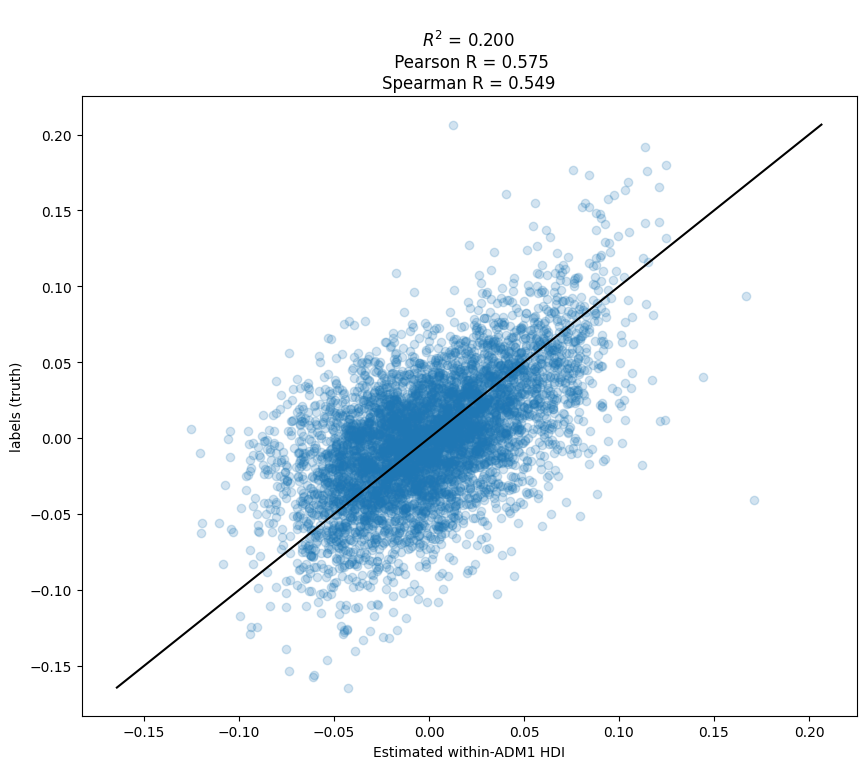

In [28]:
from analysis.prediction_utils import make_train_pred_scatterplot

make_train_pred_scatterplot("",data["within_adm1_true"],data["within_adm1_pred"], x_label="Estimated within-ADM1 HDI")

holdout r2: -1.450
holdout Pearson R: 0.693




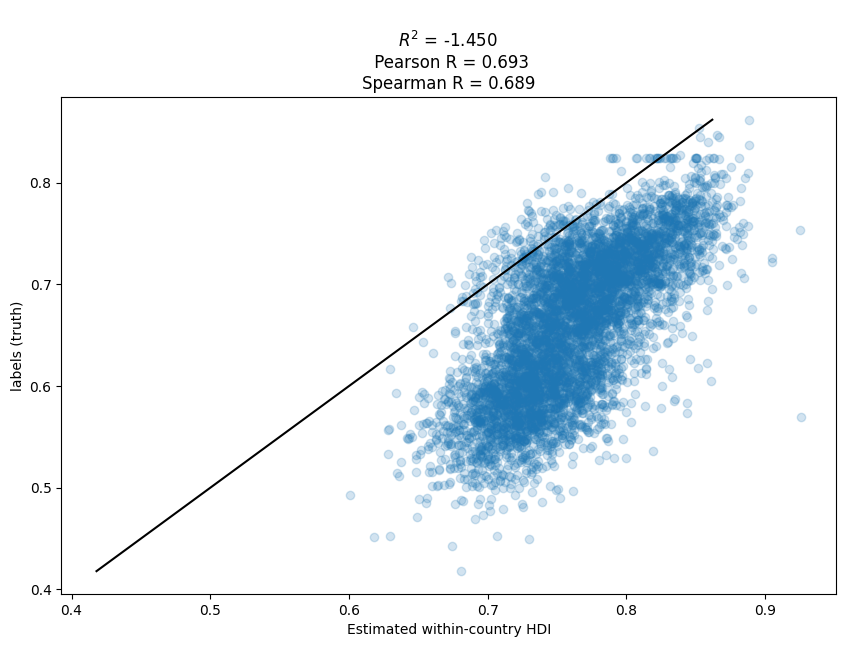

In [29]:
make_train_pred_scatterplot("",data["mhdi"],data["adm2_pred"], x_label="Estimated within-country HDI")

In [30]:
data

,shapeID,shapeName,shapeISO,shapeGroup,shapeType,ADM1_shapeID,ADM0_shapeID,ADMHIERARCHY,geometry,GDL_ADM1,...,census_code,overlap_perc,Codmun7,mhdi,within_adm0_true,within_adm0_pred,adm1_pred_mean,adm1_true_mean,within_adm1_pred,within_adm1_true
0,BRA-ADM2-3_0_0-B1,AbaÃ­ra,None,BRA,ADM2,BRA-ADM1-3_0_0-B26,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B1|BRA-ADM1-3_0_0-B26|BRA-ADM0-...,"POLYGON ((-41.90904 -13.31112, -41.87084 -13.3...",BRAr116,...,2900108,0.925614,2900108,0.603,-0.056941,-0.056379,0.740,0.593630,-0.035366,0.009370
1,BRA-ADM2-3_0_0-B2,AceguÃ¡,None,BRA,ADM2,BRA-ADM1-3_0_0-B4,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B2|BRA-ADM1-3_0_0-B4|BRA-ADM0-3...,"POLYGON ((-54.45486 -31.65346, -54.35098 -31.7...",BRAr123,...,4300034,0.989678,4300034,0.687,0.027059,-0.046176,0.781,0.713896,-0.066164,-0.026896
2,BRA-ADM2-3_0_0-B3,AnagÃ©,None,BRA,ADM2,BRA-ADM1-3_0_0-B26,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B3|BRA-ADM1-3_0_0-B26|BRA-ADM0-...,"POLYGON ((-41.09346 -14.44130, -41.06813 -14.4...",BRAr116,...,2901205,0.986434,2901205,0.540,-0.119941,-0.045819,0.740,0.593630,-0.024806,-0.053630
3,BRA-ADM2-3_0_0-B4,Aroeiras,None,BRA,ADM2,BRA-ADM1-3_0_0-B9,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B4|BRA-ADM1-3_0_0-B9|BRA-ADM0-3...,"POLYGON ((-35.82522 -7.45981, -35.82908 -7.495...",BRAr112,...,2501302,0.979516,2501302,0.548,-0.111941,-0.033751,0.740,0.587104,-0.012738,-0.039104
4,BRA-ADM2-3_0_0-B5,Alfredo Chaves,None,BRA,ADM2,BRA-ADM1-3_0_0-B1,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B5|BRA-ADM1-3_0_0-B1|BRA-ADM0-3...,"POLYGON ((-40.98786 -20.43685, -40.96897 -20.4...",BRAr118,...,3200300,0.969292,3200300,0.710,0.050059,-0.010488,0.769,0.692584,-0.018475,0.017416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5580,BRA-ADM2-3_0_0-B5582,SÃ£o JoÃ£o da Canabrava,None,BRA,ADM2,BRA-ADM1-3_0_0-B11,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B5582|BRA-ADM1-3_0_0-B11|BRA-AD...,"POLYGON ((-41.51069 -6.60787, -41.49524 -6.667...",BRAr109,...,2209856,0.980897,2209856,0.559,-0.100941,-0.055578,0.719,0.571130,-0.013565,-0.012130
5581,BRA-ADM2-3_0_0-B5583,SÃ­tio Novo do Tocantins,None,BRA,ADM2,BRA-ADM1-3_0_0-B25,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B5583|BRA-ADM1-3_0_0-B25|BRA-AD...,"POLYGON ((-47.83833 -5.59899, -47.67908 -5.594...",BRAr107,...,1720804,0.987982,1720804,0.604,-0.055941,-0.000094,0.755,0.639928,0.005919,-0.035928
5582,BRA-ADM2-3_0_0-B5584,UrÃ¢nia,None,BRA,ADM2,BRA-ADM1-3_0_0-B7,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B5584|BRA-ADM1-3_0_0-B7|BRA-ADM...,"POLYGON ((-50.73365 -20.31187, -50.69116 -20.3...",BRAr120,...,3555802,0.967272,3555802,0.746,0.086059,0.035020,0.793,0.739600,0.003033,0.006400
5583,BRA-ADM2-3_0_0-B5585,Utinga,None,BRA,ADM2,BRA-ADM1-3_0_0-B26,BRA-ADM0-3_0_0-B1,BRA-ADM2-3_0_0-B5585|BRA-ADM1-3_0_0-B26|BRA-AD...,"POLYGON ((-41.22867 -12.13873, -41.11492 -12.1...",BRAr116,...,2932804,0.982930,2932804,0.590,-0.069941,-0.040636,0.740,0.593630,-0.019623,-0.003630


### Now we make the big table with results from all models

In [31]:
all_model_preds = pd.read_pickle(data_dir + "preds/hdi_preds_from_all_models_at_adm2.p").loc[data["shapeID"]]
all_model_preds = all_model_preds.merge(data.set_index("shapeID")[["GDL_ADM1","mhdi"]], "left", left_index=True, right_index=True)

def get_perf_metrics(col, df, truth_col="mhdi"):
    perf = {}
    
    within_adm0_true = df[truth_col] - df[truth_col].mean()
    within_adm0_pred = df[col] - df[col].mean()
    
    perf["within_adm0_pearson"] = np.corrcoef( within_adm0_true,within_adm0_pred )[0,1] **2
    perf["within_adm0_spearman"] = spearmanr(within_adm0_true,within_adm0_pred ).correlation
    perf["within_adm0_r2"]  = sklearn.metrics.r2_score(within_adm0_true,within_adm0_pred )
    
    grouped = all_model_preds.groupby("GDL_ADM1")[[col, truth_col]].mean().rename(columns = {col:"adm1_pred_grouped_mean", 
                                                                              truth_col:"adm1_truth_grouped_mean"})
    df = df.merge(grouped, "left", left_on="GDL_ADM1", right_index=True )
    
    within_adm1_true = df[truth_col] - df["adm1_truth_grouped_mean"]
    within_adm1_pred = df[col] - df["adm1_pred_grouped_mean"]
    
    perf["within_adm1_pearson"] = np.corrcoef( within_adm1_true,within_adm1_pred )[0,1] **2
    perf["within_adm1_spearman"] = spearmanr(within_adm1_true,within_adm1_pred ).correlation
    perf["within_adm1_r2"]  = sklearn.metrics.r2_score(within_adm1_true,within_adm1_pred )
    
    return perf
    
    
    
    
perf_dict = {}
for col in all_model_preds.columns[:-2]:
    perf_dict[col] = get_perf_metrics(col, all_model_preds)

In [32]:
## Make Table

rename_dict = { "within_adm0_pearson": "$\rho^{2}$", "within_adm0_spearman":"Spearman r", "within_adm0_r2":"$R^{2}$",
               "within_adm1_pearson": "$\rho^{2}$", "within_adm1_spearman":"Spearman r", "within_adm1_r2":"$R^{2}$"}

table = pd.DataFrame(perf_dict).T.round(2)
table[table <= 0] = "$< 0$"
table = table.rename(columns = rename_dict).reset_index(drop=True)

table.loc[0:2,"Indonesia HDI"] = "\textbf{Province level}"
table.loc[3:5,"Indonesia HDI"] = "\textbf{Country level}"
table.loc[6:9,"Indonesia HDI"] = "\textbf{Within-country}"

table.loc[0:2,""] = ["\textbf{MOSAIKS+VIIRS}","\textbf{MOSAIKS}","\textbf{VIIRS}"]
table.loc[3:5,""] = ["\textbf{MOSAIKS+VIIRS}","\textbf{MOSAIKS}","\textbf{VIIRS}"]
table.loc[6:8,""] = ["\textbf{MOSAIKS+VIIRS}","\textbf{MOSAIKS}","\textbf{VIIRS}"]

table.loc[9] = "\textbf{Predicted at municipality level in Brazil" +  " (n={:,})".format(len(data))

table.loc[10] = "\emph{Within-country performance}"
table.iloc[10,3:6] = "\emph{Within-province performance}"

table.drop(columns="Spearman r", inplace=True)

table.loc[11] = ("(" + pd.Series(np.arange(1,table.shape[1]+1)).astype(str) +")").to_numpy()

table = table.T.reset_index().set_index([9,10,"index",11])

tab = table.T

tab.columns.names = ([None, None, None,None])

table = tab.set_index([tab.columns[-2],tab.columns[-1]])

table.index.names =["\emph{ \textbf{" + "HDI" + " trained at:}}", "\emph{ \textbf{Features}}"]
table = table.iloc[[6,7,8,0,1,2,3,4,5]]
table


/tmp/ipykernel_17700/803695978.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$< 0$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table[table <= 0] = "$< 0$"


\textbf{Predicted at municipality level in Brazil (n=5,584)  \
                                                                                     \emph{Within-country performance}   
                                                                                                            $\rho^{2}$   
                                                                                                                   (1)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                                               
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}                                                  0.48            
                                 \textbf{MOSAIKS}                                                        0.42            
                                 \textbf{VIIRS}                                                          0.56            
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}                                                  0.46            
                                 \textbf{MOSAIKS}                                                        0.33            
                                 \textbf{VIIRS}                                                           0.2            
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}                                                  0.29            
                                 \textbf{MOSAIKS}                                                        0.19            
                                 \textbf{VIIRS}                                                          0.22            

                                                                    \
                                                                     
                                                           $R^{2}$   
                                                               (2)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}       0.48   
                                 \textbf{MOSAIKS}             0.42   
                                 \textbf{VIIRS}               0.53   
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}       0.36   
                                 \textbf{MOSAIKS}            $< 0$   
                                 \textbf{VIIRS}              $< 0$   
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}      $< 0$   
                                 \textbf{MOSAIKS}            $< 0$   
                                 \textbf{VIIRS}              $< 0$   

                                                                                               \
                                                           \emph{Within-province performance}   
                                                                                   $\rho^{2}$   
                                                                                          (3)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                      
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}                                  0.33   
                                 \textbf{MOSAIKS}                                         0.2   
                                 \textbf{VIIRS}                                          0.41   
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}                                  0.31   
                                 \textbf{MOSAIKS}                                        0.18   
                                 \textbf{VIIRS}                                          0.32   
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}                                  0.18   
                                 \textbf{MOSAIKS}                                        0.08   
                                 \textbf{VIIRS}                                          0.31   

          